In [5]:
cd /Users/cl1704/PycharmProjects/clustering_in_rnns/Experiment_6

/Users/cl1704/PycharmProjects/clustering_in_rnns/Experiment_6


In [6]:
from ParametricWMTask import generate_trials
#from Experiment_5.SiegelMillerTask import generate_trials
import networkx as nx
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from net import *
import os
import statsmodels.api as sm
import scipy.optimize as opt
import math
#from psychometrics import *
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import networkx as nx
from sklearn.cluster import KMeans

plt.rcParams["axes.grid"] = False
from sklearn.manifold import TSNE

matplotlib.rcParams['axes.linewidth'] = .75

10.0
10.0
10.0


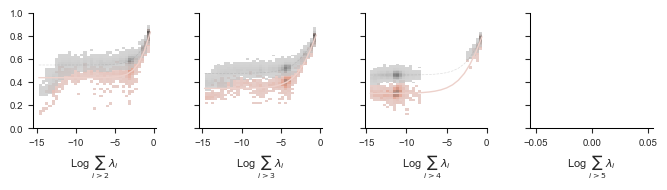

In [7]:
def compute_var(variance, n):
    return np.sum(variance[n:])


def compute_p(k, null_k):
    return np.sum(null_k < k) / len(null_k)


import scipy.optimize as opt
import math

fig = plt.figure(figsize=(8, 1.5))
gs = gridspec.GridSpec(1, 4, wspace=.35)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[0, 3])
axes = [ax0, ax1, ax2, ax3]

df_list = []
for filename in os.listdir('Results_6'):
    f = os.path.join('Results_6', filename)
    if os.path.isfile(f):
        df_list.append(pd.read_pickle(f))
original_df = pd.concat(df_list, ignore_index=True)
original_df = original_df[original_df.mse_z < .06]
#original_df = original_df[original_df.activity_std<.05]
#original_df = original_df[original_df.n>50]

#original_df = original_df[original_df.dim==5]
#original_df = original_df[original_df.sigma_rec==0.]
#original_df = original_df[original_df.lr==.005]


#original_df = original_df[original_df.k>1]
parameters = []
fit_rows = []

for i in range(3):
    ax = axes[i]
    k = 4 + i
    df = original_df.copy()
    df['var'] = df.variance.apply(lambda x: compute_var(x, k))

    df['k_inertia'] = df.inertia.apply(lambda x: x[k - 1])
    df['var'] = np.log(df['var'])
    #df = df[df.k>=k]
    df = df[df.dim == k]
    print(df.lvar.max())
    #print(df.lvar.min())
    #df = df[df['var']<-.35]

    # Construct null dataframe
    rows = []
    for index, row in df.iterrows():
        null = row['null_inertia']
        for run in range(null.shape[1]):
            rows.append({'model_id': row['model_id'],
                         'var': row['var'],
                         'lambda_std': row['lambda_std'],
                         'beta': row['beta'],
                         'run': run,
                         'inertia': null[k - 1, run]})
    null_df = pd.DataFrame(rows)
    #null_df = null_df.groupby(['model_id']).mean().reset_index()
    sns.histplot(data=df, x='var', y='k_inertia', ax=ax, legend=False, alpha=.75, hue='lambda_std', bins=(35, 35))
    sns.histplot(data=null_df, x='var', y='inertia', ax=ax, legend=False, alpha=.75, bins=(35, 35), color='gray')


    def f(x, a, b, c, d):
        #return a + c * np.log(1 + np.exp(b * (x-d))) / b
        #return a + c*np.log(1+np.exp(20 * (x-b)))/20
        return a + b / (1 + np.exp(c * (x - d)))


    # bounds = ([0,0,-np.inf,-np.inf],
    #               [np.inf, np.inf,0,0])
    bounds = ([0, 0, -np.inf, -np.inf],
              [np.inf, np.inf, 0, 0])
    x_values = np.linspace(df['var'].min(), df['var'].max(), 20)
    for lambda_std in [0.1, 0.2]:
        for sample in range(25):
            #try:
            frac = .5
            sample_df = df[(df.lambda_std == lambda_std)].sample(frac=frac)
            x = sample_df['var'].values.astype(float)
            y = sample_df.k_inertia.values

            sample_null_df = null_df[(null_df.lambda_std == lambda_std)].sample(frac=frac)
            x_null = sample_null_df['var'].values.astype(float)
            y_null = sample_null_df.inertia.values

            try:
                popt, pcov = opt.curve_fit(f, x, y, method="trf", max_nfev=10000, bounds=bounds)
                #popt, pcov = opt.curve_fit(f, x, y, method="trf",max_nfev=10000)
                y_fit = f(x_values, *popt)

                for step in range(20):
                    fit_rows.append({'sample': sample,
                                     'step': step,
                                     'k': k,
                                     'lambda_std': lambda_std,
                                     'type': 1,
                                     'x': x_values[step],
                                     'y': y_fit[step],
                                     'a': popt[0]})
            except:
                continue

            try:
                popt, pcov = opt.curve_fit(f, x_null, y_null, method="trf", max_nfev=10000, bounds=bounds)
                y_fit = f(x_values, *popt)
                for step in range(20):
                    fit_rows.append({'sample': sample,
                                     'step': step,
                                     'k': k,
                                     'lambda_std': lambda_std,
                                     'type': 0,
                                     'x': x_values[step],
                                     'y': y_fit[step],
                                     'a': popt[0]})
            except:
                continue

# 
fit_df = pd.DataFrame(fit_rows)
for k in range(4):
    ax = axes[k]
    sns.lineplot(data=fit_df[(fit_df.type == 1) & (fit_df.k == 4 + k)], x='x', y='y', ax=ax, legend=False, lw=1,
                 hue='lambda_std', alpha=1, errorbar=None)
    sns.lineplot(data=fit_df[(fit_df.type == 0) & (fit_df.k == 4 + k)], x='x', y='y', ax=ax, legend=False, lw=.5,
                 color='gray', linestyle='--', alpha=.25, errorbar=None)

for ax in [ax0, ax1, ax2, ax3]:
    #     
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('', fontsize=8)
    ax.xaxis.set_tick_params(labelsize=7, bottom=True)
    ax.yaxis.set_tick_params(labelsize=7, left=True)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    # plt.yticks(list(plt.yticks()[0]) + [5.0])
    ax.set_ylim(0, 1)
    #ax.set_xlim(-10,-2)
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])

ax0.set_xlabel("Log " + r"$\sum_{i>2}\lambda_i$", fontsize=8)
ax1.set_xlabel("Log " + r"$\sum_{i>3}\lambda_i$", fontsize=8)
ax2.set_xlabel("Log " + r"$\sum_{i>4}\lambda_i$", fontsize=8)
ax3.set_xlabel("Log " + r"$\sum_{i>5}\lambda_i$", fontsize=8)
fig.savefig('/Users/cl1704/PycharmProjects/Clustering/Figures/MainFig_1_a.jpg',
            format='jpeg',
            dpi=450,
            bbox_inches='tight'

            )

In [4]:
df = original_df.copy()
#df = df[df.sigma_rec==0.]
# Restrict to networks with dim and compute variance above dim
dim = 4


df = df[df.dim == dim]
df = df[df.k >= dim]
df['var'] = df.variance.apply(lambda x: compute_var(x,dim))
df['k_inertia'] = df.inertia.apply(lambda x: x[dim-1])
df['var'] = np.log(df['var'])

df.sort_values('var',ascending=True).head(20)

#original_df.weight_decay = original_df.weight_decay == 0.001c

,model_id,w_rec,w_in,w_out,bias,mse_z,epochs,sigma_rec,sigma_in,beta,...,lambda_std,n,lvar,dim,k,inertia,null_inertia,variance,var,k_inertia
3604,ZVmo8yvd,"[[0.0, 0.0020468289, -0.00503247, -0.012058466...","[[-0.122572, -0.26087686], [-0.01966849, -0.00...","[[-0.013125615, 0.031765748, -0.041788805, 0.0...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.004407,1000,0.5,0.1,100.0,...,0.2,84,10.000000,4,7,"[0.9585100198412698, 0.5428024305555555, 0.274...","[[0.999426628978824, 0.9913512939841072, 0.986...","[0.5344646, 0.45080873, 0.013445118, 0.0012753...",-11.986068,0.186548
3612,AWQhXffc,"[[0.0, -0.00047576008, -0.055541854, 0.0145305...","[[-0.024611248, -0.22957297], [-0.23898314, -0...","[[-0.026867379, -0.012100502, -0.020871507, -0...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.004853,1000,0.5,0.1,100.0,...,0.2,74,10.000000,4,8,"[0.9061495495495495, 0.5450368243243243, 0.301...","[[0.9941390160604867, 0.9853656375292562, 0.97...","[0.5220069, 0.4587062, 0.018253855, 0.00102574...",-11.825172,0.152723
3611,03Y0MYxp,"[[0.0, 0.04156355, -0.009313841, -0.0025194883...","[[-0.1303456, 0.1296699], [-0.1773602, 0.03933...","[[-0.046361756, 0.03249498, 0.047719494, 0.025...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.007254,1000,0.5,0.1,100.0,...,0.2,71,10.000000,4,7,"[0.8856718175671148, 0.48982658331297924, 0.29...","[[0.9933770344315171, 0.9973116908432696, 0.95...","[0.56483924, 0.4156487, 0.01893532, 0.00056906...",-11.770702,0.155981
3541,7rt6FL5n,"[[0.0, 0.013943276, -0.04043948, -0.004044121,...","[[-0.03765704, -0.22116694], [-0.1052352, -0.1...","[[0.021461789, -0.010776858, 0.014643866, -0.0...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.009098,1000,0.5,0.1,100.0,...,0.2,82,6.812921,4,8,"[0.9641652511859246, 0.5118400890568925, 0.291...","[[0.9912998389867259, 0.9989668507830679, 0.98...","[0.55617356, 0.42433774, 0.018525248, 0.000955...",-11.682515,0.178739
3538,iTdRBrDp,"[[0.0, -0.030436596, -0.05174025, 0.008726966,...","[[-0.04241776, 0.037947964], [0.018370805, -0....","[[-0.08302773, 0.056614395, 0.027265208, -0.03...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.004740,1000,0.5,0.1,100.0,...,0.2,84,6.812921,4,8,"[0.9740420634920635, 0.5324981150793651, 0.284...","[[0.9947803207888902, 0.996159802365597, 0.984...","[0.53757226, 0.4487052, 0.012200908, 0.0015125...",-11.611131,0.184136
3617,njesUzQW,"[[0.0, -0.0049457336, -0.016459707, -0.0343604...","[[0.08290245, -0.14529842], [-0.009660028, -0....","[[0.016511377, -0.040470693, -0.010845674, -0....","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.007306,1000,0.5,0.1,100.0,...,0.2,78,10.000000,4,8,"[0.9166942307692307, 0.5389371260683761, 0.280...","[[0.9856525820590208, 0.997697280584547, 0.989...","[0.5161593, 0.46053836, 0.022147946, 0.0011447...",-11.547649,0.170124
3606,SLTzhnhK,"[[0.0, 0.00069901295, 0.01159589, -0.041553218...","[[-0.23558947, 0.036096565], [-0.0035284492, -...","[[-0.050174482, -0.010150995, 0.028158648, 0.0...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.005056,1000,0.5,0.1,100.0,...,0.2,72,10.000000,4,7,"[0.8977477430555556, 0.5442535300925926, 0.264...","[[0.9886107722617945, 0.9972227999825802, 0.99...","[0.51989883, 0.4565606, 0.022351893, 0.0011786...",-11.520138,0.184045
3602,Mtk6LZ6Y,"[[0.0, 0.0021473444, -0.025664613, -0.04440761...","[[-0.0651153, -0.00031352555], [0.013752734, -...","[[0.010073693, 0.022312071, 0.0053614224, -0.0...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.004858,1000,0.5,0.1,100.0,...,0.2,82,10.000000,4,8,"[0.9317589361543634, 0.6008758232597381, 0.318...","[[0.9696692300454425, 0.9832290419818118, 0.99...","[0.5428231, 0.43790293, 0.017756872, 0.0015062...",-11.422138,0.169561
3522,5qdI5DPA,"[[0.0, 0.015884815, 0.0032998195, 0.009262986,...","[[-0.06421892, 0.18727688], [0.19206654, -0.02...","[[-0.008132626, 0.020701947, 0.058178164, -0.0...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.003824,1000,0.5,0.1,100.0,...

7
(100, 3750)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/cl1704/PycharmProjects/clustering_in_rnns/Experiment_6/Figures/Fig_2afc_b.jpg'

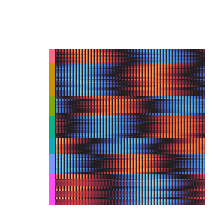

In [11]:
df = original_df.copy()
#net = torch.load('net.pth')
model_data = df[df.model_id=='ZVmo8yvd']
net = Net(n=100,input_size = 2,dale=False,base_in=0.2)
net.recurrent_layer.weight.data = torch.tensor(model_data['w_rec'].item())
net.recurrent_layer.bias.data = torch.tensor(model_data['bias'].item())
net.input_layer.weight.data = torch.tensor(model_data['w_in'].item())
net.input_layer.bias.data = torch.tensor(0.2).float()
net.output_layer.weight.data = torch.tensor(model_data['w_out'].item())
net.output_layer.bias.data = torch.tensor(-0.2).float()
#net.activation = nn.Softplus(beta=torch.tensor(model_data['beta'].item()))
net.sigma_in = 0.
net.sigma_rec = 0.

u, z, mask, conditions  = generate_trials(
                            n_trials=25)
x = net(u).detach().cpu().numpy()


# Condition averages
rows = []
for k in range(u.shape[0]):
    rows.append({'trial': k,
                 'theta': conditions[k]['theta'],
                 'response': x[k, :, :]})
df = pd.DataFrame(rows)
df = df.groupby('theta').response.apply(lambda r: np.mean(np.stack(r), axis=0)).reset_index()
responses = np.stack(df.response.values)
responses = responses.reshape(-1, responses.shape[2]).T

# Remove outlier neurons
# z_scores = np.abs(stats.zscore(np.mean(x, axis=(0, 1))))
# good_indices = np.where(z_scores < 2)[0]
# responses = responses[good_indices,:]
#n_active = np.mean(responses, axis=1) > .025
n_active =np.mean(responses, axis=1) > .025
#lower_percentile = np.percentile(np.mean(responses, axis=1),5)
#responses = responses[np.mean(responses, axis=1) > .025, :]

# Compute number of active units


# z_score
responses = (responses - np.mean(responses, axis=1, keepdims=True)) / np.std(responses, axis=1, keepdims=True)
responses = responses[~np.isnan(responses).any(axis=1)]



            
#_,k = compute_k(responses,5,25,.05)
k = model_data.k.values[0]
print(k)
print(responses.shape)
clustering = KMeans(n_clusters=k,n_init=20).fit(responses)
labels  = clustering.labels_
sort = np.argsort(labels)
sorted_responses = responses[sort,:]
sns.husl_palette(s=.4)
network_pal = sns.husl_palette(pd.Series(np.sort(labels)).unique().size,s=1)
lut = dict(zip(pd.Series(np.sort(labels)).unique(),network_pal))
row_colors = pd.Series(np.sort(labels)).map(lut)
g = sns.clustermap(pd.DataFrame((sorted_responses)),row_cluster=False, col_cluster=False, row_colors=row_colors,figsize=(2.25,2.25),cbar_pos=None, xticklabels=False, yticklabels=False,center=0)
ax = g.ax_heatmap

g.savefig('Figures/Fig_2afc_b.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight'
)

<Axes: ylabel='Count'>

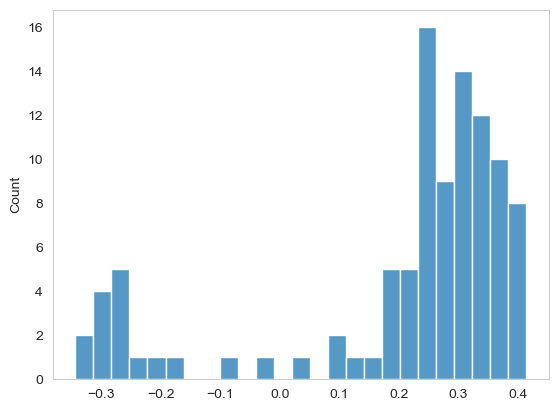

In [13]:
plt.figure()
sns.histplot(np.mean(x,axis=(0,1)),bins=25)

In [8]:
#palette = sns.color_palette("coolwarm", n_colors=50,as_cmap=False)
palette = sns.husl_palette(50,s=1)



net.sigma_in =0.05
net.sigma_rec =0
x = net.forward(u).detach().numpy()

rows = []
for k in range(u.shape[0]):
    for t in range(u.shape[1]):
        for neuron in range(x.shape[2]):
            rows.append({'trial':k,
                         'theta':conditions[k]['theta']*180/np.pi,
                        't':t,
                         'neuron': neuron,
                         'cluster': labels[neuron],
                         'response': x[k,t,neuron]})
new_df = pd.DataFrame(rows)
new_df_mean =new_df.groupby(['theta','neuron']).mean().reset_index()
# fig = plt.figure(figsize=(1.5,1.5))
# gs = gridspec.GridSpec(1,1)
# ax=fig.add_subplot(gs[0,0])

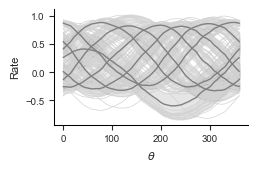

In [9]:

fig = plt.figure(figsize=(2.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])

for neuron in range(x.shape[2]):
    sns.lineplot(data = new_df_mean[new_df_mean.neuron==neuron], x = 'theta',y='response',color='lightgray',lw = .5,ax=ax)
for cluster in range(k):
    sns.lineplot(data = new_df_mean[new_df_mean.cluster==cluster], x = 'theta',y='response',color='gray',lw = 1,errorbar='sd',ax=ax)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel(r'$\theta$',fontsize=8)
ax.set_ylabel("Rate",fontsize=8)
#ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

plt.savefig('/Users/cl1704/PycharmProjects/clustering_in_rnns/Figures/Fig_2afc_b.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight'
)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/cl1704/PycharmProjects/clustering_in_rnns/Experiment_6/Figures/Fig_2afc_c.jpg'

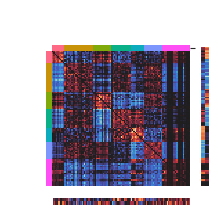

In [14]:


#sort=np.argsort(labels)
w = net.recurrent_layer.weight.data
w_in = net.input_layer.weight.data
w_out = net.output_layer.weight.data


w = w[sort,:]
w = w[:,sort]
w_in = w_in[sort,:]
w_out = w_out[:,sort]

g = sns.clustermap(pd.DataFrame(w),center=0,row_cluster=False, col_cluster=False, row_colors=row_colors, col_colors=row_colors,figsize=(2.25,2.25),cbar_pos=None, xticklabels=False, yticklabels=False)

g.gs.update(left=0.05, right=0.85,bottom=.15)
gs2 = matplotlib.gridspec.GridSpec(1,1, left=.9,top=.77,bottom=.15)
ax2 = g.fig.add_subplot(gs2[0])
sns.heatmap(w_in,ax=ax2,cbar=False,xticklabels=False,yticklabels=False,center=0)

gs3 = matplotlib.gridspec.GridSpec(1,1,left=.24,top=.1,right=.85)
ax3 = g.fig.add_subplot(gs3[0])
sns.heatmap(w_out,ax=ax3,cbar=False,xticklabels=False,yticklabels=False,center=0)


g.savefig('Figures/Fig_2afc_c.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight'
)

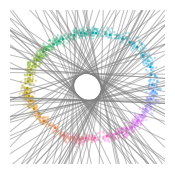

In [15]:
from sklearn.decomposition import PCA
#import seaborn as sns
from sympy import *
from sympy.plotting import plot
from sympy.plotting import plot_implicit

x = net.forward(u)
net.sigma_in = .1
n_neurons = x.shape[2]
#Restrict to act
x = x[:,:,n_active]
n_neurons = x.shape[2]
pca = PCA()
pca.fit(x.detach().numpy().reshape(-1,x.shape[2]))

U = pca.components_[:6,:].T
#U = latent_net.module_.q[:2,:].t().detach()
w = net.recurrent_layer.weight.data
w = w[n_active,:]
w = w[:,n_active]
#w = w-np.eye(50)
w_in = net.input_layer.weight.data

b = net.recurrent_layer.bias.data

H = w @ U 
#H = H[sort,:]
proj_rates = pca.transform(x.detach().reshape(-1,x.shape[2]))
proj_rates = proj_rates.reshape(-1,75,x.shape[2])

fig = plt.figure(figsize=(2,2))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])

lim =6
xx,yy = np.linspace(-lim,lim), np.linspace(-lim,lim)
x,y = np.meshgrid(xx,yy)
for i in range(n_neurons):
#for i in np.argwhere(labels==0):

    magnitude = np.linalg.norm(H[i,:].numpy())

    #ax.contour(x, y, x*H[i,0].numpy() + y*H[i,1].numpy()+b[i].numpy(), [0],colors=network_pal.as_hex()[labels[i]],linewidths=.75)
    ax.contour(x, y, x*H[i,0].numpy() + y*H[i,1].numpy()+b[i].numpy(), [0],colors='gray',linewidths=.75,alpha=.5)

#for i in range(n_neurons):
# for i in np.argwhere(labels==0):
# 
#     magnitude = np.linalg.norm(H[i,:].numpy())
# 
#     #ax.contour(x, y, x*H[i,0].numpy() + y*H[i,1].numpy()+b[i].numpy(), [0],colors=network_pal.as_hex()[labels[i]],linewidths=.75)
#     ax.contour(x, y, x*H[i,0].numpy() + y*H[i,1].numpy()+b[i].numpy(), [0],color='gray',linewidths=.75,alpha=1)


# for i in np.argwhere(labels==1):
# 
#     magnitude = np.linalg.norm(H[i,:].numpy())
# 
#     #ax.contour(x, y, x*H[i,0].numpy() + y*H[i,1].numpy()+b[i].numpy(), [0],colors=network_pal.as_hex()[labels[i]],linewidths=.75)
#     ax.contour(x, y, x*H[i,0].numpy() + y*H[i,1].numpy()+b[i].numpy(), [0],color='gray',linewidths=.75)


# for i in range(25):
#     ax.plot(proj_rates[i,57:,0],proj_rates[i,57:,1],lw=1)
       

x = net.forward(u).detach().cpu().numpy()

pca = PCA()
pca.fit(x.reshape(-1, x.shape[2]))
x_proj = pca.transform(x.reshape(-1, x.shape[2])).reshape(x.shape[0], x.shape[1], x.shape[2])
rows = []
for k in range(u.shape[0]):
    for t in range(u.shape[1]):
        rows.append({'trial': k,
                     'theta': conditions[k]['theta'],
                     't': t,
                     'z_1': x_proj[k, t, 0],
                     'z_2': x_proj[k, t, 1], })
new_df = pd.DataFrame(rows)
new_df_mean = new_df.groupby(['theta', 't']).mean().reset_index()


#sns.scatterplot(data=new_df,x='z_1',y='z_2',hue='t',ax=ax,legend=False,s=1,alpha=.1,edgecolor=None)
palette = sns.husl_palette(n_colors = 50,s = 1)
# sns.scatterplot(data=new_df_mean[new_df_mean.t<20], x='z_1', y='z_2', ax=ax, legend=False, s=3, alpha=.5,hue ='t')
sns.scatterplot(data=new_df[new_df.t==74], x='z_1', y='z_2', ax=ax, legend=False, s=3, alpha=.35, hue='theta',palette=palette)
sns.scatterplot(data=new_df_mean[new_df_mean.t==74], x='z_1', y='z_2', ax=ax, legend=False, s=5, alpha=1, hue='theta',palette=palette)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel("",fontsize=8)
ax.set_ylabel("",fontsize=8)
plt.savefig('/Users/cl1704/PycharmProjects/clustering_in_rnns/Figures/Fig1c.jpg',
            format='jpeg',
            dpi=450,
            bbox_inches='tight'
            )

FileNotFoundError: [Errno 2] No such file or directory: '/Users/cl1704/PycharmProjects/clustering_in_rnns/Experiment_6/Figures/Fig1c.jpg'

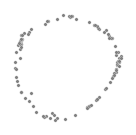

In [17]:
from scipy.stats import special_ortho_group

# x_rshp = responses
pca = TSNE()
x_proj = pca.fit_transform(responses)
# 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X = responses
y = labels
# clf = LinearDiscriminantAnalysis(tol=1e-1)
# clf.fit(X, y)
# x_proj = clf.transform(responses)

lda = LinearDiscriminantAnalysis()

#lda = TSNE(perplexity = 5)
#lda = PCA()
#reducer = umap.UMAP()
parameters = {'tol':10**np.linspace(-5,0,25)}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(lda, parameters,refit=True,error_score = np.nan,cv=5)
clf.fit(X, y)
lda = clf.best_estimator_
x_proj = lda.fit_transform(X,y)
#x_proj = PCA().fit_transform(X)

#x_proj_jitter = x_proj + 1000*(2*np.random.rand(x_proj.shape[0],x_proj.shape[1])-1)

lut = dict(zip(pd.Series(np.sort(labels)).unique(),network_pal))
row_colors = pd.Series(np.sort(labels)).map(lut)

fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.scatterplot(x=x_proj[np.argsort(labels), 0], y=x_proj[np.argsort(labels), 1], c='gray',s=6,alpha=1)
# sns.scatterplot(x=x_proj_jitter[np.argsort(labels), 0], y=x_proj_jitter[np.argsort(labels), 1], c='gray',s=6,alpha=1)
centers_proj = clf.transform(clustering.cluster_centers_)
    
    
    # total_variance = np.sum((responses.T - np.mean(responses.T, axis=0, keepdims=True)) ** 2)
    # r2 = kmeans.inertia_/total_variance
    # #x_proj = clf.fit_transform(responses)
    # sns.scatterplot(x=x_proj[np.argsort(labels), 0], y=x_proj[np.argsort(labels), 1],c=row_colors,s=1,alpha=1)
    # 
#sns.scatterplot(x=centers_proj[:, 0], y=centers_proj[:, 1], color='k',s=3,alpha=1,ax=ax,edgecolor=None)

# sns.scatterplot(x=x_proj_jitter[np.argsort(labels), 0], y=x_proj_jitter[np.argsort(labels), 1], c=row_colors,s=4,alpha=1)
#sns.kdeplot(x=x_proj[np.argsort(labels), 0], y=x_proj[np.argsort(labels), 1], hue = ,s=10,alpha=1)

#ax.scatter(x_proj[np.argsort(labels), 0],x_proj[np.argsort(labels), 1],x_proj[np.argsort(labels), 2],c=row_colors,s=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=8,bottom=True)
ax.yaxis.set_tick_params(labelsize=8,left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
# ax.set_xlim(-30,30)
# ax.set_ylim(-30,30)
plt.savefig('Figures/Fig1c.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight'
)